In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.preprocessing.sequence import TimeseriesGenerator

tf.__version__

'2.6.0'

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [28]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [29]:
#PREPROCESS DATA
df = pd.read_csv('clean_data.csv')
df = df.drop(['Unnamed: 0', 'BS_trend', 'date', 'hour', 'minute'], axis='columns')

df = pd.get_dummies(df, columns=['weekday'])

In [30]:

X = df.drop('BS', axis='columns')
y = df['BS']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

mm_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

X_train_minmax = mm_scaler.fit_transform(X_train)
X_test_minmax = mm_scaler.fit_transform(X_test)

X_train_minmax.shape

(4378, 19)

In [22]:
#remove records from data to create tensors
#X_train_minmax = X_train_minmax[:len(X_train_minmax)-10]
#y_train = y_train[:len(X_train_minmax)]


X_train_minmax.shape

(4378, 19)

In [23]:
#X_train_minmax = X_train_minmax.reshape(182, 24, 19)
#X_test_minmax = X_test_minmax.reshape(182,24,19)


In [24]:
n_input = 24
n_features = 19
generator = TimeseriesGenerator(X_train_minmax, y_train, length=n_input, batch_size=1)


print(len(generator))
batch_0 = generator[3]
x, y = batch_0

print("THIS IS X")
print(x)
print("THIS IS Y")
print(y)


4354
THIS IS X
[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.45323741
   0.         1.         0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.4676259
   0.         1.         0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.45323741
   0.         1.         0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.51798561
   0.         1.         0.         0.         0.         0.
   0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.50359712
   0.         1.         0.     

In [25]:


model = tf.keras.Sequential(
    [
        layers.LSTM(5, 
                    activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True),
        layers.LSTM(10, 
            activation='relu',
            dropout=0.1,
            recurrent_dropout=0.5,
            return_sequences=True),
        layers.LSTM(19, 
                    activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True),
        layers.LSTM(24, 
            activation='relu',
            dropout=0.1,
            recurrent_dropout=0.5,
            return_sequences=False),
        layers.Dense(24, activation='relu', dtype='float64')
    ]
)

In [26]:

model.compile(loss='mae', optimizer='adam')
#model(X_train_minmax)
#model.summary()

In [27]:
history = model.fit(x=X_train_minmax,y=y_train, shuffle=False, epochs=200, batch_size=32, validation_split=0.2)
#history = model.fit(generator, epochs=200, shuffle=False, batch_size=32)
#history = model.fit(generator, shuffle=False, epochs=200)

Epoch 1/200
4354/4354 [==============================] - 190s 41ms/step - loss: 45.9357
Epoch 2/200
4354/4354 [==============================] - 177s 41ms/step - loss: 27.7465
Epoch 3/200
4354/4354 [==============================] - 181s 42ms/step - loss: 27.1567
Epoch 4/200
4354/4354 [==============================] - 181s 42ms/step - loss: 30.6435
Epoch 5/200
4354/4354 [==============================] - 178s 41ms/step - loss: 30.8178
Epoch 6/200
4354/4354 [==============================] - 178s 41ms/step - loss: 31.5146
Epoch 7/200
3809/4354 [=========================>....] - ETA: 22s - loss: 32.2910

KeyboardInterrupt: 

In [83]:
predicted = model.predict(X_train_minmax)
predicted[-10:]

predicted = predicted.reshape(4368,)

predicted.shape


(4368,)

In [84]:

y_train.shape

y_train[-24:]

4344    126.0
4345    112.0
4346     97.0
4347     87.0
4348     89.0
4349     99.0
4350    104.0
4351    113.0
4352    121.0
4353    127.0
4354    127.0
4355    131.0
4356    137.0
4357    142.0
4358    145.0
4359    155.0
4360    159.0
4361    154.0
4362    139.0
4363    132.0
4364    134.0
4365    142.0
4366    152.0
4367    158.0
Name: BS, dtype: float64

In [85]:
predicted[-24:]

array([78.37605146, 80.27830133, 73.30273482, 77.92289083, 83.01262085,
       81.33603368, 80.92868419, 80.59594827, 78.09993123, 80.79558876,
       79.05477292, 80.43403136, 83.3702351 , 78.63230546, 82.76543456,
       81.7460617 , 80.56120051, 78.54326795, 78.30070513, 80.61621173,
       79.75625792, 83.4190476 , 78.97653202, 83.19868493])

In [86]:
mean_squared_error(y_train, predicted)

4727.3936196839795

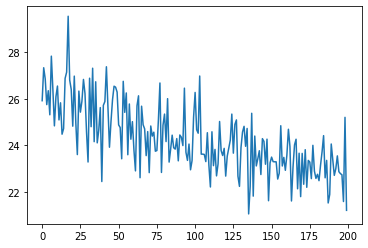

In [87]:
plt.plot(history.history['loss'])

In [80]:
[print(i) for i in range(len(y_train)) if y_train[i] == 0]

1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417
1418
1419
1420
1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]